In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import linalg as LA
import os
import pandas as pd

In [2]:
data_loc = '../dataset/'
decklist = os.listdir(data_loc)
filelist = os.listdir(data_loc+decklist[0]+'/')

length = len(decklist)*len(filelist)
imgary = np.zeros((length, 120*100))
labels = []
n=0
for i in decklist:
    for j in filelist:
        tmpimg = cv2.imread(data_loc+i+'/'+j, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))
        imgary[n] = tmpimg
        labels.append(j[:-4])
        n+=1

In [3]:
labels_shape =  [name[0]for name in labels]
labels_num =  [name[1:]for name in labels]

In [4]:
labels_shape_pd = pd.DataFrame(labels_shape)
labels_num_pd = pd.DataFrame(labels_num)

## 층화추출

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [6]:
for train_index, test_index in split.split(imgary, labels_shape):
    X_train_shape = imgary[train_index]
    y_train_shape = labels_shape_pd.loc[train_index]
    X_test_shape = imgary[test_index]
    y_test_shape = labels_shape_pd.loc[test_index]

In [7]:
for train_index, test_index in split.split(imgary, labels_num):
    X_train_num = imgary[train_index]
    y_train_num = labels_num_pd.loc[train_index]
    X_test_num = imgary[test_index]
    y_test_num = labels_num_pd.loc[test_index]

In [8]:
y_train_shape = np.array(y_train_shape).reshape(-1,)
y_test_shape = np.array(y_test_shape).reshape(-1,)
y_train_num = np.array(y_train_num).reshape(-1,)
y_test_num = np.array(y_test_num).reshape(-1,)

## 전처리

In [24]:
def pca(D, num=30):
    L = np.dot(D.T, D)
    w, v = LA.eig(L)


    # 고유값 0인거 제거    
    zero_eigen = [i for i in range(len(w)) if abs(w[i]) <1e-4]
    j=0
    for i in zero_eigen:
        w = np.delete(w, i-j, axis=0)
        v = np.delete(v, i-j, axis=1)
        j+=1

    # 고유값 내림차순으로 정렬
    ww = np.sort(w.real)[::-1]
    index = np.argsort(w.real)[::-1]  
    vv = np.array([v[:,i].real for i in list(index)]).T 

    ww = ww[:num]
    vv = vv[:, :num]

    u = np.dot(D, vv)
    u = u/(LA.norm(u, axis=0))

    weight=np.dot(u.T,D)
    return u, weight

In [36]:
""""pca_shape_save = pd.DataFrame(pca_vector_shape.T)
pca_shape_save.to_csv("pca_shape_save.csv", mode='w')""""

SyntaxError: EOL while scanning string literal (<ipython-input-36-881bb080e6a5>, line 2)

In [293]:
pca_vector_shape, X_train_shape_reduced = pca(X_train_shape.T,140)
X_test_shape_reduced=np.dot(pca_vector_shape.T,X_test_shape.T)
X_train_shape_reduced = X_train_shape_reduced.T
X_test_shape_reduced = X_test_shape_reduced.T

In [294]:
from sklearn.svm import SVC
svc_shape = SVC(kernel = 'linear', C=2, gamma = 0.05, random_state=42)
svc_shape.fit(X_train_shape_reduced, y_train_shape)
y_pred = svc_shape.predict(X_test_shape_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 6
정답률 : 0.884615


In [295]:
img = cv2.imread('cards.png', cv2.IMREAD_GRAYSCALE)
edge3 = cv2.Canny(img, 170, 200)

contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
i=0
for rect in rects2:
    card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    card_resize = cv2.resize(card, (100, 120), interpolation=cv2.INTER_AREA)
    #plt.figure()
    #plt.imshow(card_resize, cmap="gray")
    card_resize = card_resize.reshape((-1,))
    test_card_shape = np.dot(pca_vector_shape.T,card_resize.T)
    test_card_shape = test_card_shape.T.reshape(1,-1)
    print(svc_shape.predict(test_card_shape)) #, svc_num_raw.predict(card_resize))
    print("실제 결과 : %s" %test_img_result[i])
    
    i+=1

['H']
실제 결과 : H	8
['S']
실제 결과 : C	K
['C']
실제 결과 : D	5
['H']
실제 결과 : S	3
['S']
실제 결과 : C	K
['H']
실제 결과 : H	8


In [240]:
pca_vector_shape, X_train_shape_reduced = pca(X_train_shape.T,120)
X_test_shape_reduced=np.dot(pca_vector_shape.T,X_test_shape.T)
X_train_shape_reduced = X_train_shape_reduced.T
X_test_shape_reduced = X_test_shape_reduced.T

In [241]:
from sklearn.linear_model import LogisticRegression
lr_shape = LogisticRegression(solver='newton-cg', multi_class='auto', C=1.0, random_state=42)
lr_shape.fit(X_train_shape_reduced, y_train_shape)
y_pred_shape = lr_shape.predict(X_test_shape_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 9
정답률 : 0.884615


In [242]:
img = cv2.imread('cards.png', cv2.IMREAD_GRAYSCALE)
edge3 = cv2.Canny(img, 170, 200)

contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
i=0
for rect in rects2:
    card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    card_resize = cv2.resize(card, (100, 120), interpolation=cv2.INTER_AREA)
    #plt.figure()
    #plt.imshow(card_resize, cmap="gray")
    card_resize = card_resize.reshape((-1,))
    test_card_shape = np.dot(pca_vector_shape.T,card_resize.T)
    test_card_shape = test_card_shape.T.reshape(1,-1)
    print(lr_shape.predict(test_card_shape)) #, svc_num_raw.predict(card_resize))
    print("실제 결과 : %s" %test_img_result[i])
    i+=1

['H']
실제 결과 : H	8
['S']
실제 결과 : C	K
['D']
실제 결과 : D	5
['H']
실제 결과 : S	3
['S']
실제 결과 : C	K
['H']
실제 결과 : H	8


In [192]:
from sklearn.linear_model import LogisticRegression
lr_shape = LogisticRegression(solver='liblinear', multi_class='auto', C=1.0, random_state=42, max_iter=70)
lr_shape.fit(X_train_shape_reduced, y_train_shape)
y_pred_shape = lr_shape.predict(X_test_shape_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 10
정답률 : 0.923077


In [193]:
img = cv2.imread('cards.png', cv2.IMREAD_GRAYSCALE)
edge3 = cv2.Canny(img, 170, 200)

contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
i=0
for rect in rects2:
    card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    card_resize = cv2.resize(card, (100, 120), interpolation=cv2.INTER_AREA)
    #plt.figure()
    #plt.imshow(card_resize, cmap="gray")
    card_resize = card_resize.reshape((-1,))
    test_card_shape = np.dot(pca_vector_shape.T,card_resize.T)
    test_card_shape = test_card_shape.T.reshape(1,-1)
    print(lr_shape.predict(test_card_shape)) #, svc_num_raw.predict(card_resize))
    print("실제 결과 : %s" %test_img_result[i])
    i+=1

['H']
실제 결과 : H	8
['S']
실제 결과 : C	K
['D']
실제 결과 : D	5
['H']
실제 결과 : S	3
['S']
실제 결과 : C	K
['H']
실제 결과 : H	8


In [263]:
pca_vector_shape, X_train_shape_reduced = pca(X_train_shape.T,60)
X_test_shape_reduced=np.dot(pca_vector_shape.T,X_test_shape.T)
X_train_shape_reduced = X_train_shape_reduced.T
X_test_shape_reduced = X_test_shape_reduced.T

In [264]:
from sklearn.ensemble import RandomForestClassifier
rdf_shape = RandomForestClassifier(n_estimators = 80, max_depth = 20, criterion = 'entropy', random_state=42, min_samples_leaf=2, max_leaf_nodes=100)
rdf_shape.fit(X_train_shape_reduced, y_train_shape)
y_pred_shape = rdf_shape.predict(X_test_shape_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred_shape).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 20
정답률 : 0.615385


In [265]:
img = cv2.imread('cards.png', cv2.IMREAD_GRAYSCALE)
edge3 = cv2.Canny(img, 170, 200)

contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
i=0
for rect in rects2:
    card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    card_resize = cv2.resize(card, (100, 120), interpolation=cv2.INTER_AREA)
    #plt.figure()
    #plt.imshow(card_resize, cmap="gray")
    card_resize = card_resize.reshape((-1,))
    test_card_shape = np.dot(pca_vector_shape.T,card_resize.T)
    test_card_shape = test_card_shape.T.reshape(1,-1)
    print(rdf_shape.predict(test_card_shape)) #, svc_num_raw.predict(card_resize))
    print("실제 결과 : %s" %test_img_result[i])
    i+=1

['H']
실제 결과 : H	8
['H']
실제 결과 : C	K
['D']
실제 결과 : D	5
['D']
실제 결과 : S	3
['H']
실제 결과 : C	K
['H']
실제 결과 : H	8


In [196]:
pca_vector_num, X_train_num_reduced = pca(X_train_num.T,100)
X_test_num_reduced=np.dot(pca_vector_num.T,X_test_num.T)
X_train_num_reduced = X_train_num_reduced.T
X_test_num_reduced = X_test_num_reduced.T

In [77]:
pca_num_save = pd.DataFrame(pca_vector_num.T)
pca_num_save.to_csv("pca_num_save.csv", mode='w')

In [39]:
from sklearn.svm import SVC
svc_num = SVC(kernel = 'linear', C=2.0, gamma = 'auto', random_state=42)
svc_num.fit(X_train_num_reduced, y_train_num)
y_pred_num = svc_num.predict(X_test_num_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [40]:
from sklearn.linear_model import LogisticRegression
lr_num = LogisticRegression(solver='liblinear', multi_class='auto', C=70.0, random_state=42)
lr_num.fit(X_train_num_reduced, y_train_num)
y_pred_num = lr_num.predict(X_test_num_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [60]:
from sklearn.ensemble import RandomForestClassifier
rnd_num = RandomForestClassifier(max_depth = 20, random_state=42)
rnd_num.fit(X_train_num_reduced, y_train_num)
y_pred_num = rnd_num.predict(X_test_num_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 10
정답률 : 0.807692


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [84]:
contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
i=0
for rect in rects2:
    card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    card_resize = cv2.resize(card, (100, 120), interpolation=cv2.INTER_AREA)
    #plt.figure()
    #plt.imshow(card_resize, cmap="gray")
    card_resize = card_resize.reshape(1, -1)
    print(svc_shape_raw.predict(card_resize), svc_num_raw.predict(card_resize))
    print("실제 결과 : %s" %test_img_result[i])
    i+=1

['H'] ['K']
실제 결과 : H	8
['C'] ['K']
실제 결과 : C	K
['H'] ['Q']
실제 결과 : D	5
['H'] ['K']
실제 결과 : S	3
['C'] ['K']
실제 결과 : C	K
['H'] ['K']
실제 결과 : H	8


In [29]:
import pickle
from sklearn.externals import joblib

In [30]:
joblib.dump(svc_shape, 'svc_shape.pkl') 
joblib.dump(lr_shape, 'lr_shape.pkl')
joblib.dump(rnd_shape, 'rnd_shape.pkl') 
joblib.dump(svc_num, 'svc_num.pkl') 
joblib.dump(lr_num, 'lr_num.pkl') 
joblib.dump(lr_num, 'lr_num.pkl') 

['svc_shape.pkl']

In [ ]:
X_test_shape_reduced=np.dot(pca_vector_shape.T,X_test_shape.T)

In [62]:
card_resize.shape

(12000, 1)

In [61]:
pca_vector_shape.T.shape

(140, 12000)

svc :  ['S'] ['10']
logistic regression :  ['S'] ['10']


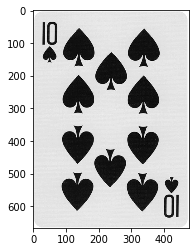

In [16]:
test_img = cv2.imread('spade10.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

['D'] ['5']
logistic regression :  ['D'] ['5']


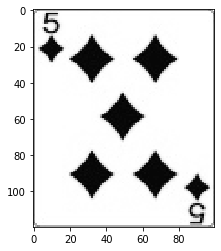

In [17]:
test_img = cv2.imread('D5.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

['H'] ['A']
logistic regression :  ['H'] ['A']


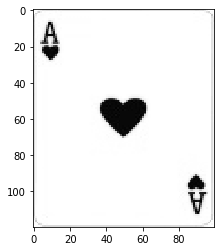

In [18]:
test_img = cv2.imread('HA.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

['S'] ['K']
logistic regression :  ['S'] ['K']


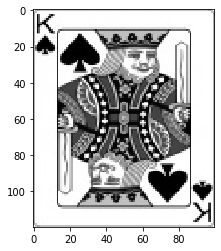

In [19]:
test_img = cv2.imread('SK.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

NameError: name 'svc_num' is not defined

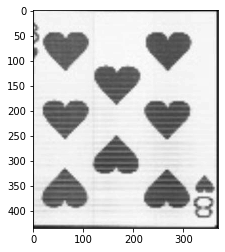

In [283]:
test_img = cv2.imread('heart8.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)
plt.imshow(test_img, cmap='gray')
print(svc_shape.predict(test_card_shape),svc_num.predict(test_card_num))
print("logistic regression : ",lr_shape.predict(test_card_shape),lr_num.predict(test_card_num))

## PCA 안쓰고 진행

### Shape

In [9]:
from sklearn.svm import SVC
svc_shape_raw = SVC(kernel = 'linear', C=1, gamma = 'auto', random_state=42)
svc_shape_raw.fit(X_train_shape, y_train_shape)
y_pred = svc_shape_raw.predict(X_test_shape)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846


In [296]:
from sklearn.svm import SVC
svc_shape_raw = SVC(kernel = 'poly', C=1, gamma = 'auto', random_state=42)
svc_shape_raw.fit(X_train_shape, y_train_shape)
y_pred = svc_shape_raw.predict(X_test_shape)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [22]:
from sklearn.linear_model import LogisticRegression
for c in range(10,205,5) :
    lr_shape_raw = LogisticRegression(solver='liblinear', multi_class='auto', C=c, random_state=42)
    lr_shape_raw.fit(X_train_shape, y_train_shape)
    y_pred_shape = lr_shape_raw.predict(X_test_shape)
    print("**************************")
    print("C : %f" %c)
    print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
    print('정답률 : %f' %((y_test_shape ==y_pred_shape).sum()/len(y_test_shape)))

**************************
C : 10.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 15.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 20.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 25.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 30.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 35.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 40.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 45.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 50.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 55.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 60.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 65.000000
총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846
**************************
C : 70.000000

In [15]:
from sklearn.linear_model import LogisticRegression

lr_shape_raw = LogisticRegression(solver='liblinear', multi_class='auto', C=100, random_state=42)
lr_shape_raw.fit(X_train_shape, y_train_shape)
y_pred_shape = lr_shape_raw.predict(X_test_shape)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred_shape).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846


In [47]:
from sklearn.ensemble import RandomForestClassifier
rnd_shape_raw = RandomForestClassifier(max_depth = 5, random_state=42)
rnd_shape_raw.fit(X_train_shape, y_train_shape)
y_pred_num = rnd_shape_raw.predict(X_test_shape)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred_shape).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred_shape).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 5
정답률 : 0.903846


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### NUMBER

In [14]:
from sklearn.svm import SVC
svc_num_raw = SVC(kernel = 'linear', C=3.0, gamma = 'auto', random_state=42)
svc_num_raw.fit(X_train_num, y_train_num)
y_pred_num = svc_num_raw.predict(X_test_num)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [298]:
from sklearn.svm import SVC
svc_shape_raw = SVC(kernel = 'poly', C=1, gamma = 'auto', random_state=42)
svc_shape_raw.fit(X_train_shape, y_train_shape)
y_pred = svc_shape_raw.predict(X_test_shape)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))
print('정답률 : %f' %((y_test_shape ==y_pred).sum()/len(y_test_shape)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [49]:
from sklearn.linear_model import LogisticRegression
for c in range(10,105,5) :
    lr_num_raw = LogisticRegression(solver='liblinear', multi_class='auto', C=c, random_state=42)
    lr_num_raw.fit(X_train_num, y_train_num)
    y_pred_num = lr_num_raw.predict(X_test_num)
    print("**************************")
    print("C : %f" %c)
    print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
    print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

KeyboardInterrupt: 

In [301]:
from sklearn.linear_model import LogisticRegression

lr_num_raw = LogisticRegression(solver='liblinear', multi_class='auto', C=100, random_state=42)
lr_num_raw.fit(X_train_num, y_train_num)
y_pred_num = lr_num_raw.predict(X_test_num)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [51]:
from sklearn.ensemble import RandomForestClassifier
rnd_num_raw = RandomForestClassifier(max_depth = 5, random_state=42)
rnd_num_raw.fit(X_train_num, y_train_num)
y_pred_num = rnd_num_raw.predict(X_test_num)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 7
정답률 : 0.865385


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


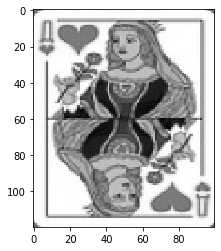

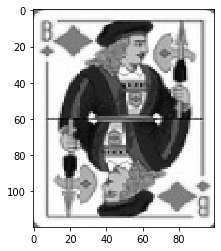

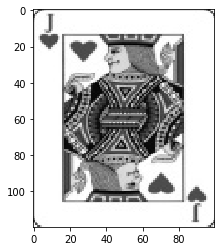

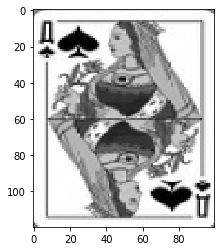

In [54]:
for img in X_test_num[(y_test_num !=y_pred_num)]:
    plt.figure()
    plt.imshow(img.reshape(120,100), cmap='gray')

svc :  ['S'] ['10']
logistic regression :  ['S'] ['10']


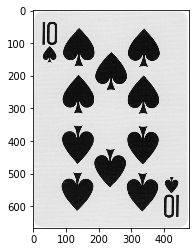

In [302]:
test_img = cv2.imread('spade10.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

In [22]:
from sklearn.svm import SVC
svc_num_raw = SVC(kernel = 'linear', C=0.01, gamma = 0.3, random_state=42)
svc_num_raw.fit(X_train_num, y_train_num)
y_pred_num = svc_num_raw.predict(X_test_num)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred_num).sum()))
print('정답률 : %f' %((y_test_num ==y_pred_num).sum()/len(y_test_num)))

총 테스트 개수 : 52, 오류개수 : 4
정답률 : 0.923077


In [10]:
img = cv2.imread('cards.png', cv2.IMREAD_GRAYSCALE)
edge3 = cv2.Canny(img, 170, 200)

In [11]:
#### 편의를 위한 결과 : 나를 위한 결과
test_img_result = ['H\t8','C\tK', 'D\t5', 'S\t3', 'C\tK', 'H\t8']

In [300]:
contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
i=0
for rect in rects2:
    card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    card_resize = cv2.resize(card, (100, 120), interpolation=cv2.INTER_AREA)
    #plt.figure()
    #plt.imshow(card_resize, cmap="gray")
    card_resize = card_resize.reshape(1, -1)
    print(svc_shape_raw.predict(card_resize), svc_num_raw.predict(card_resize))
    print("실제 결과 : %s" %test_img_result[i])
    i+=1

['C'] ['K']
실제 결과 : H	8
['C'] ['K']
실제 결과 : C	K
['S'] ['Q']
실제 결과 : D	5
['S'] ['K']
실제 결과 : S	3
['C'] ['K']
실제 결과 : C	K
['C'] ['K']
실제 결과 : H	8


In [303]:
contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
i=0
for rect in rects2:
    card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    card_resize = cv2.resize(card, (100, 120), interpolation=cv2.INTER_AREA)
    #plt.figure()
    #plt.imshow(card_resize, cmap="gray")
    card_resize = card_resize.reshape(1, -1)
    print(lr_shape_raw.predict(card_resize), svc_num_raw.predict(card_resize))
    print("실제 결과 : %s" %test_img_result[i])
    i+=1

['H'] ['K']
실제 결과 : H	8
['H'] ['K']
실제 결과 : C	K
['D'] ['Q']
실제 결과 : D	5
['D'] ['K']
실제 결과 : S	3
['H'] ['K']
실제 결과 : C	K
['H'] ['K']
실제 결과 : H	8


svc :  ['D'] ['5']
logistic regression :  ['D'] ['5']


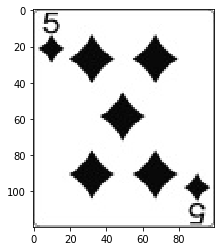

In [29]:
test_img = cv2.imread('D5.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['H'] ['A']
logistic regression :  ['H'] ['A']


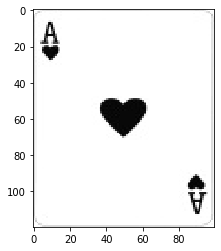

In [30]:
test_img = cv2.imread('HA.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['S'] ['K']
logistic regression :  ['S'] ['K']


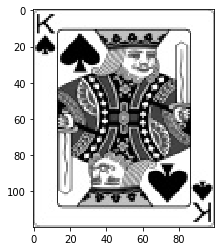

In [31]:
test_img = cv2.imread('SK.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['H'] ['K']
logistic regression :  ['H'] ['8']


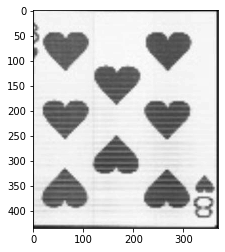

In [32]:
test_img = cv2.imread('heart8.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

svc :  ['C'] ['K']
logistic regression :  ['H'] ['K']


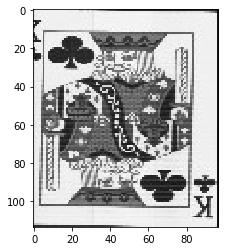

In [15]:
test_img = cv2.imread('CK.jpg', cv2.IMREAD_GRAYSCALE)
img_resize = cv2.resize(test_img, (100, 120), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((1,-1))
"""test_card_shape = np.dot(pca_vector_shape.T,img_resize.T)
test_card_shape = test_card_shape.T.reshape(1,-1)
test_card_num = np.dot(pca_vector_num.T,img_resize.T)
test_card_num = test_card_num.T.reshape(1,-1)"""
plt.imshow(test_img, cmap='gray')
print("svc : ",svc_shape_raw.predict(img_resize),svc_num_raw.predict(img_resize))
print("logistic regression : ",lr_shape_raw.predict(img_resize),lr_num_raw.predict(img_resize))

In [72]:
joblib.dump(svc_shape_raw, 'svc_shape_raw.pkl') 
joblib.dump(lr_shape_raw, 'lr_shape_raw.pkl') 
joblib.dump(rnd_shape_raw, 'rnd_shape_raw.pkl') 

joblib.dump(svc_num_raw, 'svc_num_raw.pkl') 
joblib.dump(lr_num_raw, 'lr_num_raw.pkl') 
joblib.dump(rnd_num_raw, 'rnd_num_raw.pkl') 

['rnd_num_raw.pkl']

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train_shape)

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                             

In [25]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train_shape)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test_shape, y_pred))


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression 0.5576923076923077
RandomForestClassifier 0.5192307692307693


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.34615384615384615


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier 0.5961538461538461


In [26]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train_num)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test_num, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression 0.9038461538461539
RandomForestClassifier 0.9230769230769231


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.19230769230769232


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier 0.9230769230769231


In [27]:
pca_vector, X_train_reduced_T = pca(X_train.T,50)
X_test_reduced_T=np.dot(pca_vector.T,X_test.T)
X_train_reduced = X_train_reduced_T.T
X_test_reduced = X_test_reduced_T.T

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_shape)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_shape)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_shape, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

LogisticRegression 0.25
RandomForestClassifier 0.3076923076923077
SVC 0.25


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto

VotingClassifier 0.2692307692307692


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_num)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_num)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_num, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

LogisticRegression 0.5961538461538461
RandomForestClassifier 0.3076923076923077
SVC 0.07692307692307693


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto

VotingClassifier 0.4423076923076923


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [17]:
pca_vector, X_train_reduced_T = pca(X_train.T,100)
X_test_reduced_T=np.dot(pca_vector.T,X_test.T)
X_train_reduced = X_train_reduced_T.T
X_test_reduced = X_test_reduced_T.T

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_shape)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_shape)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_shape, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

LogisticRegression 0.3076923076923077
RandomForestClassifier 0.2692307692307692
SVC 0.25
VotingClassifier 0.28846153846153844


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'au

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_num)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_num)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_num, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

LogisticRegression 0.7884615384615384
RandomForestClassifier 0.34615384615384615
SVC 0.07692307692307693


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


VotingClassifier 0.5576923076923077


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [21]:
pca_vector, X_train_reduced_T = pca(X_train.T,150)
X_test_reduced_T=np.dot(pca_vector.T,X_test.T)
X_train_reduced = X_train_reduced_T.T
X_test_reduced = X_test_reduced_T.T

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_shape)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_shape)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_shape, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

LogisticRegression 0.34615384615384615
RandomForestClassifier 0.38461538461538464
SVC 0.25


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto

VotingClassifier 0.3269230769230769


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_num)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_num)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_num, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

LogisticRegression 0.8461538461538461
RandomForestClassifier 0.3076923076923077
SVC 0.07692307692307693


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto

VotingClassifier 0.4807692307692308


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [24]:
pca_vector, X_train_reduced_T = pca(X_train.T,200)
X_test_reduced_T=np.dot(pca_vector.T,X_test.T)
X_train_reduced = X_train_reduced_T.T
X_test_reduced = X_test_reduced_T.T

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_shape)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_shape)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_shape, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

NameError: name 'accuracy_score' is not defined

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train_reduced, y_train_num)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_reduced, y_train_num)
    y_pred = clf.predict(X_test_reduced)
    print(clf.__class__.__name__, accuracy_score(y_test_num, y_pred))

c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

LogisticRegression 0.8269230769230769
RandomForestClassifier 0.28846153846153844
SVC 0.07692307692307693


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto

VotingClassifier 0.3269230769230769


c:\users\ohohk\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [6]:
from sklearn.svm import SVC
ml = SVC(kernel = 'linear', C=2.0, gamma = 'auto', random_state=0)
ml.fit(X_train, y_train_shape)
y_pred = ml.predict(X_test)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))

총 테스트 개수 : 52, 오류개수 : 24


In [7]:
from sklearn.svm import SVC
ml = SVC(kernel = 'linear', C=1.0, gamma = 'auto', random_state=42)
ml.fit(X_train, y_train_num)
y_pred = ml.predict(X_test)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num !=y_pred).sum()))

총 테스트 개수 : 52, 오류개수 : 4


In [20]:
pca_vector, X_train_reduced_T = pca(X_train.T,50)
X_test_reduced_T=np.dot(pca_vector.T,X_test.T)
X_train_reduced = X_train_reduced_T.T
X_test_reduced = X_test_reduced_T.T

In [21]:
from sklearn.svm import SVC
ml_shape = SVC(kernel = 'linear', C=1.0, gamma = 'auto', random_state=42)
ml_shape.fit(X_train_reduced, y_train_shape)
y_pred = ml_shape.predict(X_test_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))

총 테스트 개수 : 52, 오류개수 : 28


In [22]:
from sklearn.svm import SVC
ml_num = SVC(kernel = 'linear', C=1.0, gamma = 'auto', random_state=42)
ml_num.fit(X_train_reduced, y_train_num)
y_pred = ml_num.predict(X_test_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num!=y_pred).sum()))

총 테스트 개수 : 52, 오류개수 : 5


In [43]:
pca_vector, X_train_reduced_T = pca(X_train.T,60)
X_test_reduced_T=np.dot(pca_vector.T,X_test.T)
X_train_reduced = X_train_reduced_T.T
X_test_reduced = X_test_reduced_T.T

In [44]:
from sklearn.svm import SVC
ml_shape = SVC(kernel = 'linear', C=1.0, gamma = 'auto', random_state=42)
ml_shape.fit(X_train_reduced, y_train_shape)
y_pred = ml_shape.predict(X_test_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_shape), (y_test_shape !=y_pred).sum()))

총 테스트 개수 : 52, 오류개수 : 21


In [45]:
from sklearn.svm import SVC
ml_num = SVC(kernel = 'linear', C=1.0, gamma = 'auto', random_state=42)
ml_num.fit(X_train_reduced, y_train_num)
y_pred = ml_num.predict(X_test_reduced)
print('총 테스트 개수 : %d, 오류개수 : %d' %(len(y_test_num), (y_test_num!=y_pred).sum()))

총 테스트 개수 : 52, 오류개수 : 5


In [29]:
img = cv2.imread('cards.png', cv2.IMREAD_GRAYSCALE)
#edge1 = cv2.Canny(img, 50, 200)
#edge2 = cv2.Canny(img, 100, 200)
edge3 = cv2.Canny(img, 170, 200)

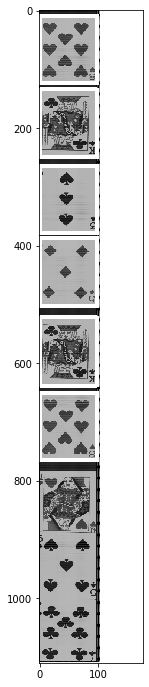

In [30]:
contours, hierarchy = cv2.findContours(edge3.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
rects2 = [(x,y,w,h) for (x,y,w,h) in rects if ((w>=95)&(w<=100)&(h>=113)&(h<=117))]
imgimg=img.copy()
for rect in rects2:
    # Draw the rectangles
    cv2.rectangle(imgimg, (rect[0], rect[1]), 
                  (rect[0] + rect[2], rect[1] + rect[3]), (255, 255, 255), 5) 

plt.figure(figsize=(15,12))
plt.imshow(imgimg,cmap="gray")

In [32]:
card = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
card = cv2.resize(card, (100,120), interpolation=cv2.INTER_AREA)
card_reshape = card.reshape((-1,))

In [33]:
card_reshape.shape

(12000,)

In [46]:
test_card=np.dot(pca_vector.T,card_reshape.T)
test_card = test_card.T.reshape(1,-1)

In [47]:
test_card.shape

(1, 60)

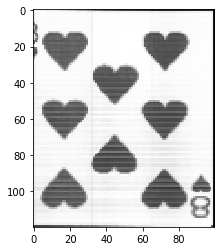

In [48]:
plt.imshow(card, cmap='gray')

In [49]:
ml_shape.predict(test_card)

array(['H'], dtype='<U1')

In [50]:
ml_num.predict(test_card)

array(['J'], dtype='<U2')

In [54]:
test_img = cv2.imread('spade10.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (120, 100), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card=np.dot(pca_vector.T,img_resize.T)
test_card = test_card.T.reshape(1,-1)
ml_shape.predict(test_card),ml_num.predict(test_card)

(array(['H'], dtype='<U1'), array(['10'], dtype='<U2'))

In [57]:
test_img = cv2.imread('D5.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
img_resize = cv2.resize(test_img, (120, 100), interpolation=cv2.INTER_AREA)
img_resize = img_resize.reshape((-1,))
test_card=np.dot(pca_vector.T,img_resize.T)
test_card = test_card.T.reshape(1,-1)
ml_shape.predict(test_card),ml_num.predict(test_card)

(array(['H'], dtype='<U1'), array(['4'], dtype='<U2'))

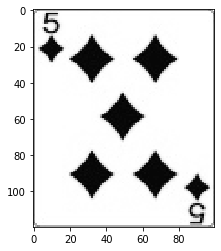

In [58]:
plt.imshow(test_img, cmap='gray')

In [3]:
"""X_train = imgary[:208]
y_train = labels[:208]
X_test = imgary[208:]
y_test = labels[208:]"""

In [14]:
"""y_train_shape = [name[0]for name in y_train[0]]
y_train_num = [name[1:]for name in y_train[0]]

y_test_shape = [name[0]for name in y_test[0]]
y_test_num = [name[1:]for name in y_test[0]]"""